In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import random
import cPickle as pickle
%matplotlib inline
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)

np.random.seed(1337)
import keras

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Plotting settings ###
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2.5
plt.rcParams['xtick.labelsize']= 24
plt.rcParams['ytick.labelsize']= 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 7
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.edgecolor'] = 'black'

def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Convolution1D(nb_filter=nbr_filters,filter_length=filter_len,input_dim=4,input_length=inp_len,border_mode=border_mode, activation='relu'))
    if layers >= 2:
        model.add(Convolution1D(nb_filter=nbr_filters,filter_length=filter_len,input_dim=4,input_length=inp_len,border_mode=border_mode, activation='relu'))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Convolution1D(nb_filter=nbr_filters,filter_length=filter_len,input_dim=4,input_length=inp_len,border_mode=border_mode, activation='relu'))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, nb_epoch=nb_epoch, verbose=1)
    return model

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq).reshape(-1)
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[x],data[y])
    return r_value**2

def eval_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq).reshape(-1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[obs_col],scaler.inverse_transform(predictions))
    return r_value**2

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## Load all EGFP data. Rename total reads and RL columns to represent each data set in the merged dataframe.
e1 & e2 = unmodified RNA EGFP........c1 & c2 = unmodified RNA mCherry

In [7]:
e1 = pd.read_pickle('../../data/egfp_unmod_1.pkl')
e1['e1_rl'] = e1['rl']
e1['e1_total'] = e1['total_reads']
e1['utr'] = e1['utr'].str[:50]

e2 = pd.read_pickle('../../data/egfp_unmod_2.pkl')
e2['e2_rl'] = e2['rl']
e2['e2_total'] = e2['total']
e2['utr'] = e2['utr'].str[:50]


df = pd.merge(e1, e2, on='utr', how='inner')
df = df[['utr', 'e1_rl', 'e2_rl', 'e1_total', 'e2_total']]

df.dropna(how='any', inplace=True)
print len(df)

e1 = None
e2 = None

323231


In [8]:
df.sort_values('e2_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:300000]
df.sort_values('e1_total', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# Train / test split --- test set is the 20k sequences with the highest number of reads
e_test = df[:20000]
e_test.reset_index(inplace=True, drop=True)
e_train = df[20000:]
e_train.reset_index(inplace=True, drop=True)

# One-hot encode UTR sequences
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale ribosome loads
e_train.loc[:,'e1_scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'e1_rl'].reshape(-1,1))
e_train.loc[:,'e2_scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'e2_rl'].reshape(-1,1))

### Load and process mCherry data

In [19]:
c1 = pd.read_pickle('../../data/mcherry_1.pkl')
c2 = pd.read_pickle('../../data/mcherry_2.pkl')
c1 = c1.rename(columns={'rl':'c1_rl','total':'c1_total'})
c2 = c2.rename(columns={'rl':'c2_rl','total':'c2_total'})
mc = pd.merge(c1,c2, on='utr', how='inner')
print len(mc)


mc.sort_values('c1_total', inplace=True, ascending=False)
mc.reset_index(inplace=True, drop=True)
mc = mc[:180000]
mc.sort_values('c2_total', inplace=True, ascending=False)
mc.reset_index(inplace=True, drop=True)
mc = mc[:170000]

mc.sort_values('c1_total', inplace=True, ascending=False)
mc.reset_index(inplace=True, drop=True)

c_train = mc[20000:]
#c_train.reset_index(inplace=True, drop=True)

c_test = mc[:20000]
#c_test.reset_index(inplace=True, drop=True)
print len(c_test), len(c_train)

# One-hot encode UTR sequences
seq_c_train = one_hot_encode(c_train,seq_len=50)
seq_c_test = one_hot_encode(c_test, seq_len=50)

c_train.loc[:,'c1_scaled_rl'] = preprocessing.StandardScaler().fit_transform(c_train.loc[:,'c1_rl'].reshape(-1,1))
c_train.loc[:,'c2_scaled_rl'] = preprocessing.StandardScaler().fit_transform(c_train.loc[:,'c2_rl'].reshape(-1,1))
c_train = c_train[['utr', 'c1_scaled_rl', 'c2_scaled_rl', 'c1_total', 'c2_total', 'c1_rl', 'c2_rl']]

191797
20000 150000


#### Train EGFP models and test on all data (EGFP and mCherry)

In [25]:
# Dictionaries to store models and model performance on all data
model_dict = {}
performance_dict = {}

# Train EGFP data & test on all samples
for sample in ['e1', 'e2']:
    m_name = sample + '_model'
    
    # Train
    model_dict[m_name] = train_model(seq_e_train, e_train[sample + '_scaled_rl'], nb_epoch=3,border_mode='same',
                       inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                       dropout2=0,dropout3=0.2)
    
    # Save model
    model = model_dict[m_name]
    
    # Evaluate on self and the other data sets
    e1 = eval_data(e_test, model, seq_e_test, 'e1_rl')
    e2 = eval_data(e_test, model, seq_e_test, 'e2_rl')
    c1 = eval_data(c_test, model, seq_c_test, 'c1_rl')
    c2 = eval_data(c_test, model, seq_c_test, 'c2_rl')
    
    # Save model performance
    performance_dict[m_name] = (e1, e2, c1, c2)
    print m_name, performance_dict[m_name]
    print

Epoch 1/3
260000/260000 [==============================] - 108s - loss: 0.3002   
Epoch 2/3
260000/260000 [==============================] - 107s - loss: 0.2040   
Epoch 3/3
260000/260000 [==============================] - 107s - loss: 0.1852   
e1_model (0.90662597436881021, 0.86244152436949972, 0.75693153645078082, 0.73745088582440455)

Epoch 1/3
260000/260000 [==============================] - 108s - loss: 0.3648   
Epoch 2/3
260000/260000 [==============================] - 107s - loss: 0.2637   
Epoch 3/3
260000/260000 [==============================] - 107s - loss: 0.2394   
e2_model (0.87934123432224609, 0.88562139481990909, 0.69521422948032707, 0.67926610422743772)



In [26]:
with open('./saved_data/cds_e_model_performance.dict', 'wb') as f:
    pickle.dump(performance_dict, f)

#### Train mCherry models and test on all data (EGFP and mCherry)

In [21]:
# Dictionaries to store models and model performance on all data
model_dict = {}
performance_dict = {}

# Train egfp data & test on all samples
for sample in ['c1', 'c2']:
    m_name = sample + '_model'
    
    # Train
    model_dict[m_name] = train_model(seq_c_train, c_train[sample + '_scaled_rl'], nb_epoch=3,border_mode='same',
                       inp_len=50, nodes=40, layers=2, nbr_filters=120, filter_len=8, dropout1=0,
                       dropout2=0.2,dropout3=0)
    
    # Save model
    model = model_dict[m_name]
    
    # Evaluate on self and the other data sets
    e1 = eval_data(e_test, model, seq_e_test, 'e1_rl')
    e2 = eval_data(e_test, model, seq_e_test, 'e2_rl')
    c1 = eval_data(c_test, model, seq_c_test, 'c1_rl')
    c2 = eval_data(c_test, model, seq_c_test, 'c2_rl')
    
    # Save model performance
    performance_dict[m_name] = (e1, e2, c1, c2)
    print m_name, performance_dict[m_name]
    print

Epoch 1/3
150000/150000 [==============================] - 37s - loss: 0.3478    
Epoch 2/3
150000/150000 [==============================] - 37s - loss: 0.2381    
Epoch 3/3
150000/150000 [==============================] - 37s - loss: 0.2105    
c1_model (0.87583118753653766, 0.81697121571373477, 0.82973391226945992, 0.80526756504980812)

Epoch 1/3
150000/150000 [==============================] - 37s - loss: 0.3661    
Epoch 2/3
150000/150000 [==============================] - 37s - loss: 0.2365    
Epoch 3/3
150000/150000 [==============================] - 37s - loss: 0.2126    
c2_model (0.84876753674603, 0.79504030270753046, 0.81445391310172155, 0.82348411063545446)



In [22]:
with open('./saved_data/cds_c_model_performance.dict', 'wb') as f:
    pickle.dump(performance_dict, f)

#### Load performance dictionaries, combine into a single dictionary, and plot

In [20]:
avg_perf = np.zeros((4,4))
new_dict = {}

# Load EGFP model performance
d = pickle.load(open('./saved_data/cds_e_model_performance.dict', 'rb'))
new_dict.update(d)

# Load mCherry model performance
d = pickle.load(open('./saved_data/cds_c_model_performance.dict', 'rb'))
new_dict.update(d)

a = np.array((new_dict['e1_model'], new_dict['e2_model'], new_dict['c1_model'], new_dict['c2_model']))
a = a.T

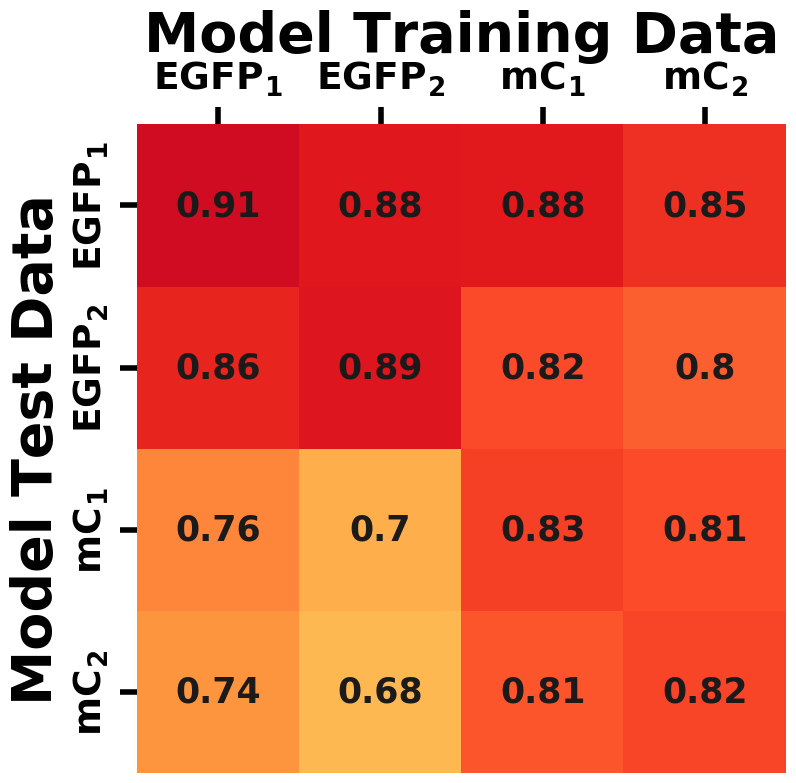

In [22]:
ax =sns.heatmap(a, annot=True, cmap='YlOrRd', vmin=0.5, vmax=1, annot_kws={'size':'25', 'color':'k'}, cbar=False, square=True)
f = ax.get_figure()
f.set_size_inches((8,8))
ax.set_xticklabels(['EGFP${_1}$', 'EGFP${_2}$', r'mC${_1}$', r'mC${_2}$'], size=27, fontdict={'family':'arial'})
ax.set_yticklabels([r'mC${_2}$', r'mC${_1}$', 'EGFP${_2}$', 'EGFP${_1}$'], size=27, fontdict={'family':'arial'})
ax.set_xlabel('Model Training Data', size = 40, fontdict={'family':'arial'})
ax.set_ylabel('Model Test Data', size=40, fontdict={'family':'arial'});
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top');
ax.xaxis.set_label_position('top');